<a href="https://colab.research.google.com/github/Shrey-Viradiya/HandsOnMachineLearning/blob/master/Anime_GAN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d splcher/animefacedataset

 97% 382M/395M [00:10<00:00, 34.4MB/s]
100% 395M/395M [00:10<00:00, 40.5MB/s]


In [3]:
!mkdir Anime
!unzip animefacedataset.zip -d Anime/

Streaming output truncated to the last 5000 lines.
  inflating: Anime/images/62765_2019.jpg  
  inflating: Anime/images/62766_2019.jpg  
  inflating: Anime/images/62767_2019.jpg  
  inflating: Anime/images/62768_2019.jpg  
  inflating: Anime/images/62769_2019.jpg  
  inflating: Anime/images/6276_2003.jpg  
  inflating: Anime/images/62770_2019.jpg  
  inflating: Anime/images/62771_2019.jpg  
  inflating: Anime/images/62772_2019.jpg  
  inflating: Anime/images/62773_2019.jpg  
  inflating: Anime/images/62774_2019.jpg  
  inflating: Anime/images/62775_2019.jpg  
  inflating: Anime/images/62776_2019.jpg  
  inflating: Anime/images/62777_2019.jpg  
  inflating: Anime/images/62778_2019.jpg  
  inflating: Anime/images/62779_2019.jpg  
  inflating: Anime/images/6277_2003.jpg  
  inflating: Anime/images/62780_2019.jpg  
  inflating: Anime/images/62781_2019.jpg  
  inflating: Anime/images/62782_2019.jpg  
  inflating: Anime/images/62783_2019.jpg  
  inflating: Anime/images/62784_2019.jpg  
  inf

# Anime GAN

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from time import time

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
path_dataset = './Anime/'
image_dataset = './Anime/images/'

In [4]:
images = os.listdir(image_dataset)

Text(0.5, 1.0, '43484_2013.jpg')

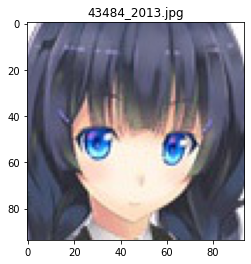

In [5]:
name1 = images[np.random.randint(0,len(images))]
path1 = image_dataset + name1
plt.imshow(Image.open(path1))
plt.title(name1)

In [6]:
total_images = len(images)
batch_size = 128

In [7]:
data_gen = keras.preprocessing.image.ImageDataGenerator(rescale= 1./255)

In [8]:
faces = data_gen.flow_from_directory(path_dataset, target_size = (112,112), class_mode=None, batch_size = batch_size)

Found 63565 images belonging to 1 classes.


In [9]:
list(faces.image_shape)

[112, 112, 3]

In [10]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*256, input_shape = [codings_size]),
    keras.layers.Reshape([7,7,256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128, kernel_size = 5, strides = 2,
                                padding = 'same', activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size = 5, strides = 2,
                                padding = 'same', activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, kernel_size = 5, strides = 2,
                                padding = 'same', activation = 'selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size = 5, strides = 2,
                                padding = 'same', activation = 'tanh')
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size =5, strides = 2, padding = 'same',
                       activation = keras.layers.LeakyReLU(0.2),
                       input_shape = list(faces.image_shape)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=5, strides = 2, padding='same',
                       activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides = 2, padding='same',
                       activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [12]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'sgd')
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy', optimizer = 'sgd')

In [13]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [14]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=1):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        start = time()
        i = 0
        total_et = total_images//batch_size
        while i < total_et:
            # print(i)
            X_batch = dataset.next()
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
            i+=1
        new_faces = generator(tf.random.normal(shape=[batch_size, codings_size]))
        plt.figure(figsize = ( 5 * 1.5, 26 * 1.5))
        plot_multiple_images(new_faces, n_cols=7)
        plt.show()
        dataset.next() #Drop Remainder
        print(f"Duration {time() - start} s")

Epoch 1/20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 540x2808 with 0 Axes>

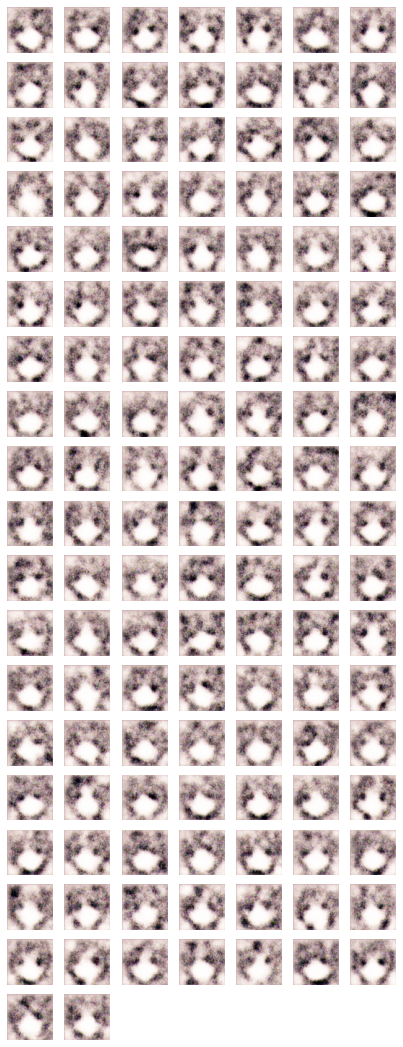

Duration 270.9402241706848 s
Epoch 2/20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 540x2808 with 0 Axes>

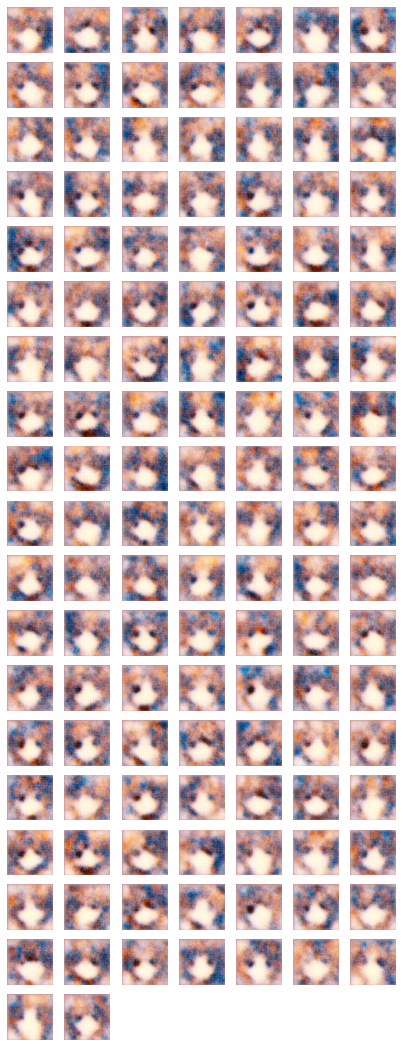

Duration 267.8186933994293 s
Epoch 3/20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 540x2808 with 0 Axes>

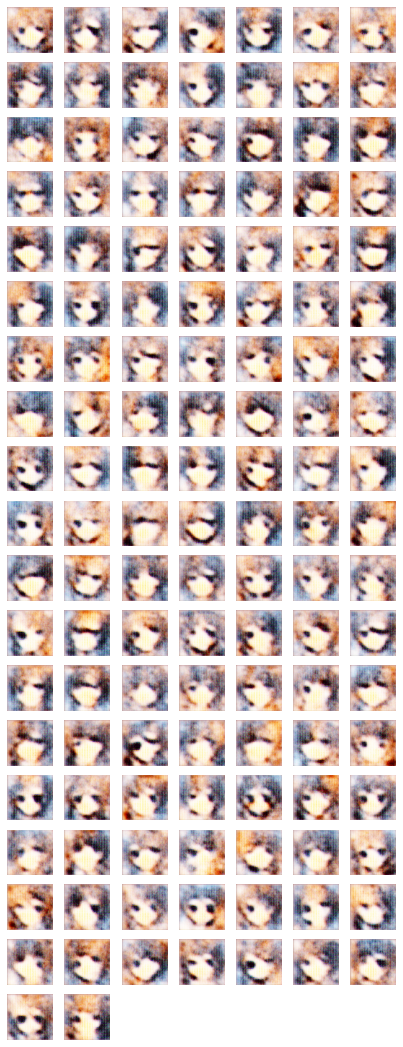

Duration 269.6812448501587 s
Epoch 4/20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 540x2808 with 0 Axes>

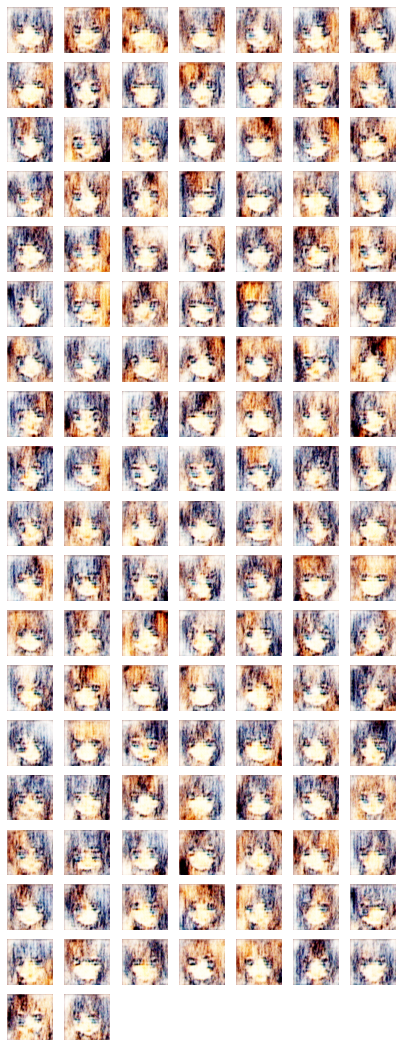

Duration 268.03939175605774 s
Epoch 5/20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 540x2808 with 0 Axes>

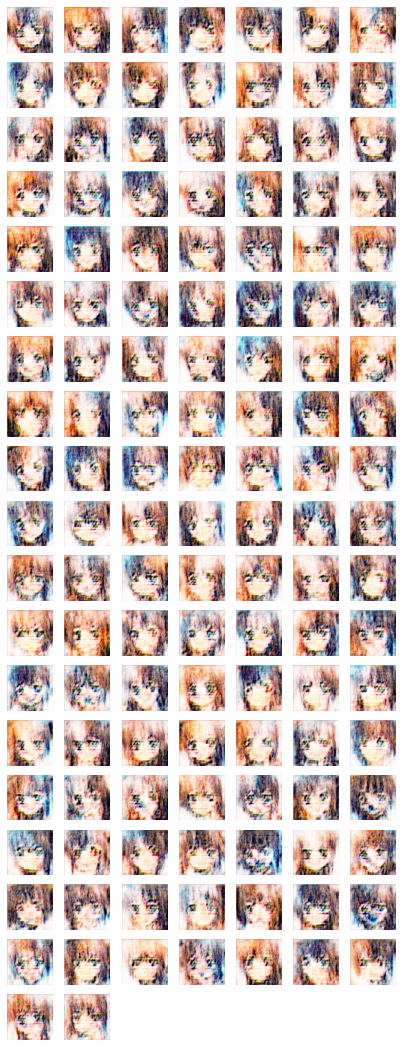

Duration 268.4058041572571 s
Epoch 6/20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 540x2808 with 0 Axes>

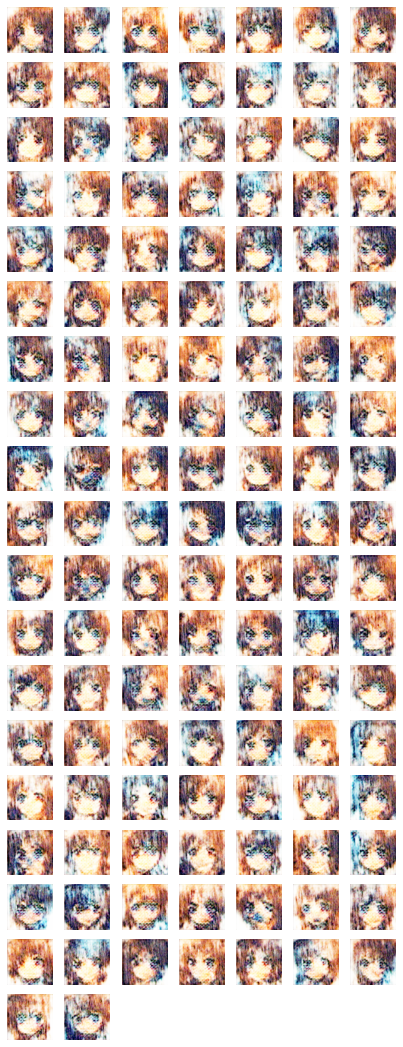

Duration 268.4858498573303 s
Epoch 7/20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 540x2808 with 0 Axes>

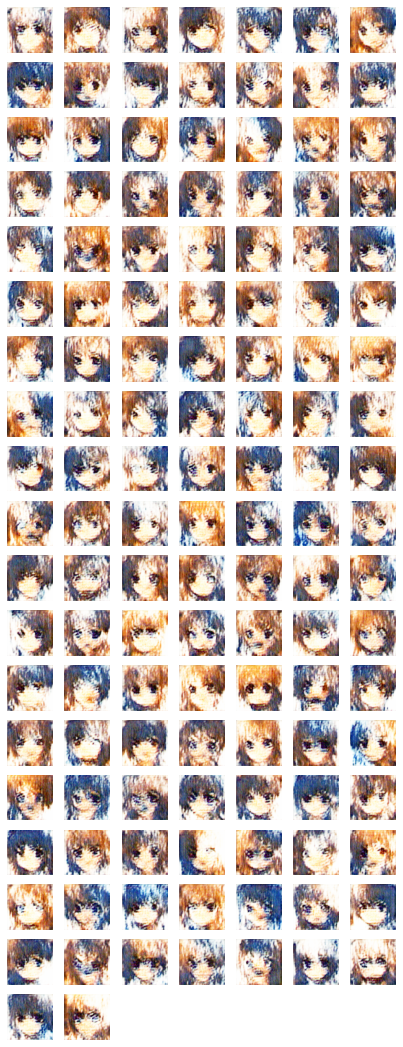

Duration 268.5568447113037 s
Epoch 8/20


KeyboardInterrupt: ignored

In [15]:
train_gan(gan, faces, batch_size, codings_size, n_epochs=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 540x2808 with 0 Axes>

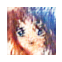

In [17]:
new_faces = generator(tf.random.normal(shape=[1, codings_size]))
plt.figure(figsize = ( 5 * 1.5, 26 * 1.5))
plot_multiple_images(new_faces, n_cols=5)
plt.show()